In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib

import os
import sys
import datetime

#import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable


import torchvision
import torchvision.transforms as transforms

In [2]:
#matplotlib.rcParams['figure.figsize'] = (12,7) # Til rapport
matplotlib.rcParams['figure.figsize'] = (20,10) # Til undervejs

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(torch.version.cuda)
print(device)
#Ikke i brug endnu

9.0.176
cuda:0


## Kode til at gemme modeltilstande

In [4]:
def SaveState(model):
    x = datetime.datetime.now()
    filename = '../checkpoints/multi_model_state_%s.pt' % (x.strftime("%Y%m%d-%H%M"))
    torch.save(model.state_dict(), filename)
    print('Model saved as:\n%s' % os.path.abspath(filename))
    
def LoadState(filename):
    model = torch.load(filename)
    model.eval()
    return model

## Indlæs data
Det antages at dataen ligger i `'../data'`

In [5]:
data_raw = np.load('../data/cullpdb+profile_5926.npy')

## Omform data

In [6]:
data = data_raw.reshape((-1,700,57))

In [7]:
amino_acid_recidues  = data[...,:22]
amino_seq_profiles   = data[...,35:]
sec_structure_labels = data[...,22:31]
sec_structure_actual_labels = np.argmax(sec_structure_labels, axis=2).reshape((-1, 700, 1))
solvent_access       = data[...,33:35]

a = sec_structure_actual_labels.reshape((-1, 700, 1))
b = np.concatenate((a, solvent_access), axis=2)

ext_x = np.concatenate((amino_acid_recidues, amino_seq_profiles), axis=2)
ext_y = np.concatenate((sec_structure_actual_labels, solvent_access), axis=2)

x = ext_x
y = ext_y
#x = amino_acid_recidues
#y = sec_structure_labels
#y = solvent_access

input_channels  = x.shape[2]
output_channels = y.shape[2]

print('Kanaler:\nInput:  %d\nOutput: %d' % (input_channels, output_channels))

print('Fuldt datasæt shape:')
print('X: ', x.shape)
print('Y: ', y.shape)

y_train_unrot = y[:5430]
y_test_unrot = y[5435:5690]
y_validation_unrot = y[5690:5926]

#x = x.reshape(-1,22,700)
#y = y.reshape(-1,9,700)
x = np.rot90(x, axes=(1,2))
y = np.rot90(y, axes=(1,2))

x = np.flip(x, 1)
y = np.flip(y, 1)

print('Fuldt datasæt vendt shape:')
print('X: ', x.shape)
print('Y: ', y.shape)

x_train = x[:5430]
y_train = y[:5430]

x_test = x[5435:5690]
y_test = y[5435:5690]

x_validation = x[5690:5926]
y_validation = y[5690:5926]

print('Splittet ud i training og testing:')
print('(Train) X: ', x_train.shape)
print('(Train) Y: ', y_train.shape)
print('(Test)  X: ', x_test.shape)
print('(Test)  Y: ', y_test.shape)
print('(Validation)  X: ', x_validation.shape)
print('(Validation)  Y: ', y_validation.shape)

torch_X_train = torch.from_numpy(x_train).type(torch.FloatTensor).to(device)
torch_Y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)
torch_X_test  = torch.from_numpy(x_test).type(torch.FloatTensor).to(device)
torch_Y_test  = torch.from_numpy(y_test).type(torch.LongTensor).to(device)
torch_X_validation  = torch.from_numpy(x_validation).type(torch.FloatTensor).to(device)
torch_Y_validation  = torch.from_numpy(y_validation).type(torch.LongTensor).to(device)

## Sæt data sammen i DataLoader

In [11]:
BATCH_SIZE = 5 # 250 har virket godt før

train = torch.utils.data.TensorDataset(torch_X_train, torch_Y_train)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)

## Definér modellen

In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=input_channels,       
                out_channels=layer_widths[0],      
                kernel_size=kernel_sizes[0],        
                stride=1,             
                padding=int(kernel_sizes[0]/2),            
            ),                        
            nn.ReLU(),                
        )
        self.conv2 = nn.Sequential(   
            nn.Conv1d(
                in_channels=layer_widths[0],       
                out_channels=layer_widths[1],      
                kernel_size=kernel_sizes[1],        
                stride=1,             
                padding=int(kernel_sizes[1]/2),            
            ),                        
            nn.ReLU(),                
        )
        self.conv3 = nn.Sequential(   
            nn.Conv1d(
                in_channels=layer_widths[1],       
                out_channels=layer_widths[2],      
                kernel_size=kernel_sizes[2],        
                stride=1,             
                padding=int(kernel_sizes[2]/2),            
            ),                        
            nn.ReLU(),                
        )
        self.conv4 = nn.Sequential(     
            nn.Conv1d(
                in_channels=layer_widths[2],       
                out_channels=layer_widths[3],       
                kernel_size=kernel_sizes[3],
                stride=1,             
                padding=int(kernel_sizes[3]/2),            
            ),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(     
            nn.Conv1d(
                in_channels=layer_widths[3],
                out_channels=layer_widths[4],       
                kernel_size=kernel_sizes[4],
                stride=1,             
                padding=int(kernel_sizes[4]/2),            
            ),
            nn.ReLU(),
        )
        self.out = nn.Sequential(     
            nn.Conv1d(
                in_channels=layer_widths[4],       
                out_channels=11,       
                kernel_size=kernel_sizes[5],
                stride=1,             
                padding=int(kernel_sizes[5]/2),            
            ),
            #nn.ReLU(),
            #nn.Softmax(dim=1),
        )
#        self.soft = nn.Softmax(dim=1)
#        self.relu = nn.ReLU()
#        self.sig1 = torch.nn.Sigmoid()
#        self.sig2 = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        output = self.out(x)
        #secondary_structures = self.soft(output[:,:-2,:])
        secondary_structures = output[:,:-2,:]
        #rel_solvent_acc = self.sig1(output[:,-2,:])
        #abs_solvent_acc = self.sig2(output[:,-1,:])
        rel_solvent_acc = output[:,-2,:]
        abs_solvent_acc = output[:,-1,:]
        
        return secondary_structures, rel_solvent_acc, abs_solvent_acc 

## Instantiér modellen

In [47]:
layer_width = 80
kernel_size = 11
layer_widths = [layer_width]*5
kernel_sizes = [5, 7, 9, 11, 13, 15]  # Bedste so far : [5, 21, 11, 5]

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)   
#cnn = smartCNN(layer_widths, kernel_sizes)#.to(device)
cnn = CNN().to(device)
print(cnn)
print('Model is on device: "%s"' % device)
# Hyperparametre
LR = 0.00025       # learning rate

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
sigge = nn.Sigmoid()
#loss_func_train = nn.BCELoss()  #Binary Cross Entropy Loss
loss_func_train = nn.CrossEntropyLoss()
loss_func_solvent = nn.BCEWithLogitsLoss()
#loss_func2 = nn.BCELoss()  #Binary Cross Entropy Loss
loss_func_valid = nn.BCELoss()
loss_func_test  = nn.BCELoss()

CNN(
  (conv1): Sequential(
    (0): Conv1d(44, 80, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(80, 80, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(80, 80, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(80, 80, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv1d(80, 80, kernel_size=(13,), stride=(1,), padding=(6,))
    (1): ReLU()
  )
  (out): Sequential(
    (0): Conv1d(80, 11, kernel_size=(15,), stride=(1,), padding=(7,))
  )
)
Model is on device: "cuda:0"


## Funktion til at måle accuracy

In [33]:
def CalculateAccuracy(calc_values_structure, calc_values_rel, calc_values_abs, real_values):
    NoSeq = 8                                                                     # Hvilken værdi er padding?
    real_values_structure = real_values[:,:,0]                                  # Split de korrekte værdier ud i sæt
    real_values_relsolv   = real_values[:,:,1]
    real_values_abssolv   = real_values[:,:,2]
    
    #real_labels = real_values_structure
    
    #real_labels = np.argmax(real_values_structure, axis=2)                        # Kollaps one-hot til rene labels
    real_mask = real_values_structure == NoSeq                                              # Lav maske af dem der er NoSeq
    
    calc_values_structure = calc_values_structure.cpu().detach().numpy()          # Omform til numpy
    calc_values_structure = np.flip(calc_values_structure, 1)                     # Omgør spejlning og 
    calc_values_structure = np.rot90(calc_values_structure, k=-1, axes=(1,2))     # rotation
    
    calc_relsolv = sigge(calc_values_rel).cpu().detach().numpy()                         # Omform til numpy
    #calc_relsolv = np.flip(calc_relsolv, 1)                   # Omgør spejlning og       # Find i øvrigt lige ud af hvorfor de ikke skal rettes!
    #calc_relsolv = np.rot90(calc_relsolv, k=-1)#, axes=(1,2))   # rotation
    
    calc_abssolv = sigge(calc_values_abs).cpu().detach().numpy()                         # Omform til numpy
    #calc_abssolv = np.flip(calc_abssolv, 1)                   # Omgør spejlning og 
    #calc_abssolv = np.rot90(calc_abssolv, k=-1)#, axes=(1,2))   # rotation
    
    calc_labels  = np.argmax(calc_values_structure, axis=2)                       # Kollaps one-hot til rene labels
    calc_relsolv = np.around(calc_relsolv)                                        # Afrund til enten 0 eller 1
    calc_abssolv = np.around(calc_abssolv)                                        # Afrund til enten 0 eller 1
    
    correct_structures = calc_labels == real_labels                               # Lav en matrice af korrekte forudsigelser
    correct_structures_masked = np.ma.masked_array(correct_structures, real_mask) # Filtrér dem er er NoSeq
    
    correct_relsolv = calc_relsolv == real_values_relsolv                         # Lav en matrice af korrekte forudsigelser
    correct_relsolv_masked = np.ma.masked_array(correct_relsolv, real_mask)       # Filtrér dem er er NoSeq
    
    correct_abssolv = calc_abssolv == real_values_abssolv                         # Lav en matrice af korrekte forudsigelser
    correct_abssolv_masked = np.ma.masked_array(correct_abssolv, real_mask)       # Filtrér dem er er NoSeq
    
    structure_mean = np.mean(correct_structures_masked)                           # Tag gennemsnittet af struktur-sættet
    relsolv_mean   = np.mean(correct_relsolv_masked)                              # Tag gennemsnittet af relativ solvent-sættet
    abssolv_mean   = np.mean(correct_abssolv_masked)                              # Tag gennemsnittet af absolut solvent-sættet
    
    return structure_mean, relsolv_mean, abssolv_mean

## Sammensat loss-funktion
Tager som input en loss-funktion (som i dette tilfælde er Binary Cross Entropy), tre beregnede matricer af hhv. sekundærstrukturer og relativ- og absolut solvent accessibility, anvender loss-funktionen på dem alle og returnerer summen.

In [39]:
def handleLoss(loss_function, calc_struct, calc_rel, calc_abs, correct, verbose=False):
    #print(calculated[:,9,:])
    #print(second_x)
    #first_x  = calculated_struct
    #second_x = calculated_rel
    #third_x  = calculated_abs
    
    correct_struct  = correct[:,0,:]
    correct_rel     = correct[:,1,:].type(torch.FloatTensor).to(device)
    correct_abs     = correct[:,2,:].type(torch.FloatTensor).to(device)
    
    loss1 = loss_function(calc_struct,  correct_struct)
    loss2 = loss_func_solvent(calc_rel, correct_rel)
    loss3 = loss_func_solvent(calc_abs,  correct_abs)
    if verbose:
        print('Secondary structure loss: %.4f' % loss1.item())
        print('Relative solvent accessibility loss: %.4f' % loss2.item())
        print('Absolute solvent accessibility loss: %.4f' % loss3.item())
    loss_sum = (loss1 + loss2 + loss3)
    #loss1.backward(retain_graph=True)
    #loss3.backward(retain_graph=True)
    #loss2.backward(retain_graph=True)
    return loss_sum

## Endelig test af accuracy

In [ ]:
def TestsetTest(model):
    print('Running on the test set:')
    a, b, c = model(torch_X_test)
    tloss = handleLoss(loss_func_train, a, b, c, torch_Y_test, verbose=True)
    x, y, z = CalculateAccuracy(a, b, c, y_test_unrot)
    testRes = '%.3f%%, %.3f%%, %.3f%%' % (x*100, y*100, z*100)
    #sys.stdout.write('Total loss: %.5f,\tAccuracy (struct, rel, abs): %.3f%%, %.3f%%, %.3f%%' % (tloss.item(), x*100, y*100, z*100))
    return testRes

In [48]:
# Til visualisering senere
losses       = []
acc_structs1 = []
acc_structs2 = []
acc_structs3 = []
acc_structs4 = []
acc_structs5 = []
acc_structs6 = []
acc_structs7 = []
acc_structs8 = []
acc_rels     = []
acc_abss     = []
steps        = []

In [49]:
steps_cum    = []

In [50]:
epochs       = []

## Træn modellen

In [52]:
EPOCH = 5

time_start = datetime.datetime.now()

#acc_structs6 = []

step_cum = -1
for epoch in range(EPOCH):
    print('\nEpoch: ', epoch+1)
    epochs.append(step_cum)
    for step, (b_x, b_y) in enumerate(train_loader):
        step_cum += 1
        a, b, c = cnn(b_x)
        optimizer.zero_grad()           # clear gradients for this training step
        loss = handleLoss(loss_func_train, a, b, c, b_y)
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        if step % 50 == 0:
            v_a, v_b, v_c = cnn(torch_X_validation)
            vloss = handleLoss(loss_func_train, v_a, v_b, v_c, torch_Y_validation)
            acc_struc, acc_rel, acc_abs = CalculateAccuracy(v_a, v_b, v_c, y_validation_unrot)
            validresults = '%.2f%%, %.2f%%, %.2f%%' % (acc_struc*100, acc_rel*100, acc_abs*100)
            sys.stdout.write('\rStep [%d]:\tTrain:[Loss: %.5f] \t Validation:[Loss: %.4f, Accuracies (struc, rel, abs): %.2f%%, %.2f%%, %.2f%%]' % (step, loss.item(), vloss.item(), acc_struc*100, acc_rel*100, acc_abs*100))
            #epochs.append(epoch)
            #losses.append(vloss.item())
            acc_structs1.append(acc_struc)
            #acc_rels.append(acc_rel)
            #acc_abss.append(acc_abs)
            #steps.append(step)
            steps_cum.append(step_cum)
            
print('\nDone training.')
time_end = datetime.datetime.now()
testresults = TestsetTest(cnn)
text_to_print = '%s\t%s || %s' % (str(kernel_sizes), validresults, testresults)
print(text_to_print)
print(time_end - time_start)


Epoch:  1
Step [1050]:	Train:[Loss: 0.70874] 	 Validation:[Loss: 0.4952, Accuracies (struc, rel, abs): 68.22%, 82.43%, 80.85%]
Epoch:  2
Step [1050]:	Train:[Loss: 0.36541] 	 Validation:[Loss: 0.4897, Accuracies (struc, rel, abs): 68.60%, 82.46%, 81.01%]
Epoch:  3
Step [1050]:	Train:[Loss: 0.39553] 	 Validation:[Loss: 0.4809, Accuracies (struc, rel, abs): 69.65%, 82.64%, 81.04%]
Epoch:  4
Step [1050]:	Train:[Loss: 0.49333] 	 Validation:[Loss: 0.4749, Accuracies (struc, rel, abs): 70.14%, 82.78%, 81.32%]
Epoch:  5
Step [1050]:	Train:[Loss: 0.34965] 	 Validation:[Loss: 0.4736, Accuracies (struc, rel, abs): 70.10%, 82.80%, 81.28%]
Done training.
Running on the test set:
Secondary structure loss: 0.2495
Relative solvent accessibility loss: 0.1140
Absolute solvent accessibility loss: 0.1253
[5, 7, 9, 11, 13, 15]	70.10%, 82.80%, 81.28% || 70.172%, 82.387%, 80.722%
0:01:08.681989


tensor([ 4.3831,  2.3270,  2.7236,  0.0416,  1.1893,  3.4065,  0.9929, -0.7115,
         4.9904,  3.5285,  2.2617,  6.2438,  4.7665,  0.2901,  3.1532,  2.1191,
        -2.1507,  0.5586,  3.2473, -1.2888], device='cuda:0',
       grad_fn=<SliceBackward>)
[[1. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [20]:
#matplotlib.rcParams['figure.figsize'] = (12,7) # Til rapport
matplotlib.rcParams['figure.figsize'] = (20,10) # Til undervejs

In [105]:
kernel11 = acc_structs4.copy()
kernel13 = acc_structs5.copy()

In [19]:
testresults = TestsetTest(cnn)
print(testresults)

Running on the test set:
Secondary structure loss: 0.0513
Relative solvent accessibility loss: 0.1150
Absolute solvent accessibility loss: 0.1262
68.906%, 82.588%, 80.581%


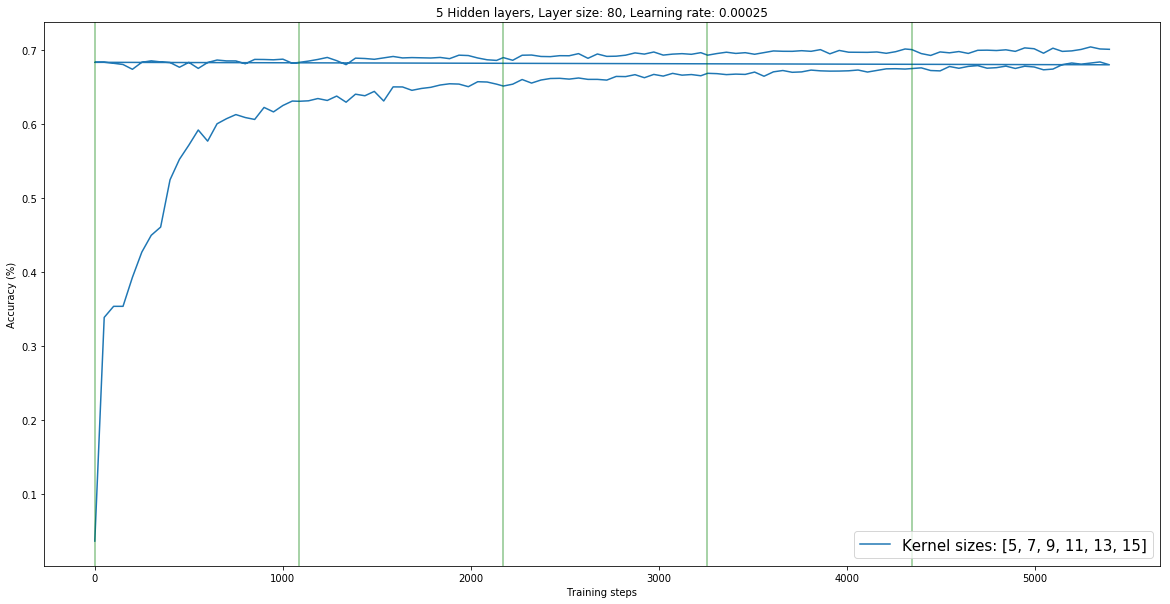

In [53]:
#steps = np.arange(0, len(acc_structs1)*50, 50)
LW=2
plt.plot(steps_cum, acc_structs1, label='Kernel sizes: [5, 7, 9, 11, 13, 15]')#, lw=LW)
#plt.plot(steps_cum, acc_structs2, label='Kernel sizes: [7, 7, 11, 11, 13, 13]')#, lw=LW)
#plt.plot(steps_cum, acc_structs3, label='Kernel sizes: [15, 13, 11, 9, 7, 5]')#, lw=LW)
#plt.plot(steps_cum, acc_structs4, label='Kernel sizes: [15, 15, 11, 11, 7, 7]')#, lw=LW)
#plt.plot(steps_cum, acc_structs5, label='Kernel sizes: [5, 15, 13, 11, 9, 7]')#, lw=LW)
#plt.plot(steps_cum, acc_structs6, label='Kernel sizes: [7, 9, 11, 13, 15, 17]')#, lw=LW)
#plt.plot(steps_cum, acc_structs7, label='Kernel sizes: ')#, lw=LW)
#plt.plot(steps_cum, kernel11, label='Kernel size: 11')#, lw=LW)
#plt.plot(steps_cum, kernel13, label='Kernel sizes: ')#, lw=LW)

for i in epochs:
    plt.axvline(x=i, alpha=0.25, c='g')

plt.title('5 Hidden layers, Layer size: 80, Learning rate: 0.00025')
plt.xlabel('Training steps')
plt.ylabel('Accuracy (%)')
plt.legend(prop={'size': 15})
plt.show()
#plt.savefig('../graphs/kernel_size_variations_1.png')

In [22]:
SaveState(cnn)

Model saved as:
/home/simonsen/Documents/Uni/bachelor/git/Bachelor19/checkpoints/multi_model_state_20190603-1420.pt
